In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
from xgboost import XGBRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, r2_score, f1_score

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')

holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')

submission = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')

-----------

# Outputting Data for Visualization --

In [3]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [5]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [6]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [7]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [8]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


-------------------

In [9]:
print("Train Keys:", train.keys())
print("Test Keys:", test.keys())

Train Keys: Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')
Test Keys: Index(['id', 'date', 'store_nbr', 'family', 'onpromotion'], dtype='object')


-------------------

In [10]:
print("Train Data: ")
display(train.isnull().sum())

print()
print("---")
print()

print("Test Data: ")
display(test.isnull().sum())

print()
print("---")
print()

print("Oil Data: ")
display(oil.isnull().sum())

print()
print("---")
print()

print("Stores Data: ")
display(stores.isnull().sum())

print()
print("---")
print()

print("Transactions Data: ")
display(transactions.isnull().sum())

print()
print("---")
print()

print("Holiday Events: ")
display(holidays.isnull().sum())

Train Data: 


id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


---

Test Data: 


id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64


---

Oil Data: 


date           0
dcoilwtico    43
dtype: int64


---

Stores Data: 


store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64


---

Transactions Data: 


date            0
store_nbr       0
transactions    0
dtype: int64


---

Holiday Events: 


date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

-------------------

# **Data Analysis/Visualization**

**Sales per Date --**

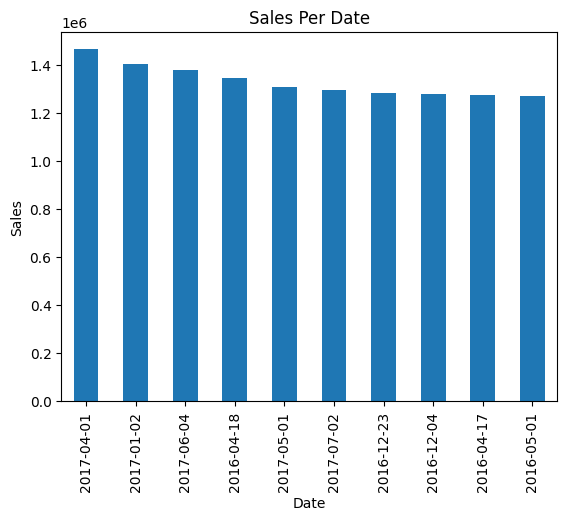

In [11]:
sales_per_date = train.groupby("date")["sales"].sum()
sales_per_date.sort_values(ascending = False)[:10].plot.bar(xlabel = "Date", ylabel = "Sales", title = "Sales Per Date");

-------------------

**Sales per Store --**

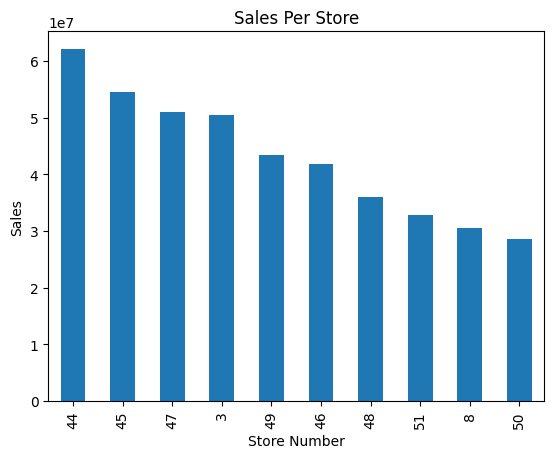

In [12]:
sales_per_store = train.groupby("store_nbr")["sales"].sum()
sales_per_store.sort_values(ascending = False)[:10].plot.bar(xlabel = "Store Number", ylabel = "Sales", title = "Sales Per Store");

-------------------

**On Promotion --**

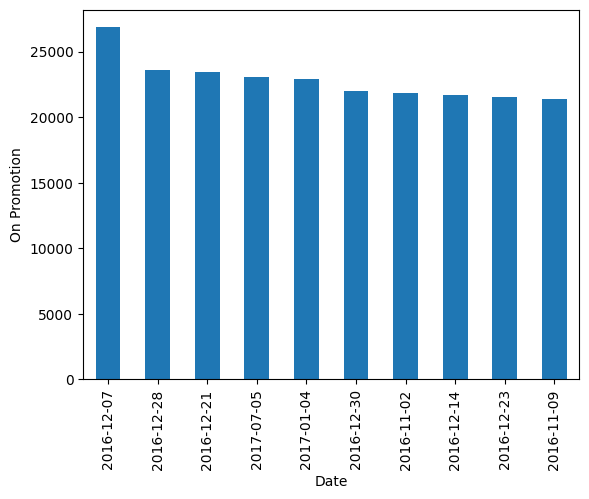

In [13]:
sales_per_store = train.groupby("date")["onpromotion"].sum()
sales_per_store.sort_values(ascending = False)[:10].plot.bar(xlabel = "Date", ylabel = "On Promotion");

-------------------

# **Modifying the Data --**

In [14]:
# Merging Oil with Transactions based on the dates with a left join. All entries from Oil will be kept regardless.
oil_trans = pd.merge(oil,transactions,on='date', how='left') 

# Dropping na values from oil
oil_trans = oil_trans.dropna()

# Merging Train with updated Oil based on dates and store numbers. This is a left join again to keep everything for Train regardless.
train_oil = pd.merge(train, oil_trans, on=['date', 'store_nbr'], how='left')

# Mean Value for 'transactions' considering it has multiple null values.
mValue = train_oil['transactions'].mean()
train_oil['transactions'] = train_oil['transactions'].fillna(mValue)

train_oil = train_oil.drop('dcoilwtico', axis=1)

train_oil

,id,date,store_nbr,family,sales,onpromotion,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,1611.874153
1,1,2013-01-01,1,BABY CARE,0.000,0,1611.874153
2,2,2013-01-01,1,BEAUTY,0.000,0,1611.874153
3,3,2013-01-01,1,BEVERAGES,0.000,0,1611.874153
4,4,2013-01-01,1,BOOKS,0.000,0,1611.874153
...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,2155.000000
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2155.000000
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,2155.000000
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2155.000000


In [15]:
# Doing the same left join of Test and Oil as above.
test = pd.merge(test, oil_trans, on=['date', 'store_nbr'], how='left')

# Updating 'transactions' with the mean value on test as well.
test['transactions'] = test['transactions'].fillna(mValue)

test = test.drop('dcoilwtico', axis=1)

test

,id,date,store_nbr,family,onpromotion,transactions
0,3000888,2017-08-16,1,AUTOMOTIVE,0,1611.874153
1,3000889,2017-08-16,1,BABY CARE,0,1611.874153
2,3000890,2017-08-16,1,BEAUTY,2,1611.874153
3,3000891,2017-08-16,1,BEVERAGES,20,1611.874153
4,3000892,2017-08-16,1,BOOKS,0,1611.874153
...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,1611.874153
28508,3029396,2017-08-31,9,PREPARED FOODS,0,1611.874153
28509,3029397,2017-08-31,9,PRODUCE,1,1611.874153
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,1611.874153


-------------------

In [16]:
# Converting the 'date' column to a datetime object
train_oil['date'] = pd.to_datetime(train_oil['date'])

# Grabbing specific dates from the datetime object
train_oil['year'] = train_oil['date'].dt.year
train_oil['month'] = train_oil['date'].dt.month
train_oil['day'] = train_oil['date'].dt.day
train_oil['day_of_week'] = train_oil['date'].dt.dayofweek

# The 'date' column is now unnecessary, so we can remove it
train_oil.drop('date',axis=1,inplace=True)

In [17]:
# Converting the 'date' column to a datetime object to test as well
test['date'] = pd.to_datetime(test['date'])

# Grabbing specific dates from the datetime object
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['day_of_week'] = test['date'].dt.dayofweek

# The 'date' column is now unnecessary, so we can remove it
test.drop('date', axis=1, inplace=True)

-------------

# **Checking Updates --**

In [18]:
train_oil

,id,store_nbr,family,sales,onpromotion,transactions,year,month,day,day_of_week
0,0,1,AUTOMOTIVE,0.000,0,1611.874153,2013,1,1,1
1,1,1,BABY CARE,0.000,0,1611.874153,2013,1,1,1
2,2,1,BEAUTY,0.000,0,1611.874153,2013,1,1,1
3,3,1,BEVERAGES,0.000,0,1611.874153,2013,1,1,1
4,4,1,BOOKS,0.000,0,1611.874153,2013,1,1,1
...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,9,POULTRY,438.133,0,2155.000000,2017,8,15,1
3000884,3000884,9,PREPARED FOODS,154.553,1,2155.000000,2017,8,15,1
3000885,3000885,9,PRODUCE,2419.729,148,2155.000000,2017,8,15,1
3000886,3000886,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2155.000000,2017,8,15,1


In [19]:
test

,id,store_nbr,family,onpromotion,transactions,year,month,day,day_of_week
0,3000888,1,AUTOMOTIVE,0,1611.874153,2017,8,16,2
1,3000889,1,BABY CARE,0,1611.874153,2017,8,16,2
2,3000890,1,BEAUTY,2,1611.874153,2017,8,16,2
3,3000891,1,BEVERAGES,20,1611.874153,2017,8,16,2
4,3000892,1,BOOKS,0,1611.874153,2017,8,16,2
...,...,...,...,...,...,...,...,...,...
28507,3029395,9,POULTRY,1,1611.874153,2017,8,31,3
28508,3029396,9,PREPARED FOODS,0,1611.874153,2017,8,31,3
28509,3029397,9,PRODUCE,1,1611.874153,2017,8,31,3
28510,3029398,9,SCHOOL AND OFFICE SUPPLIES,9,1611.874153,2017,8,31,3


--------------

# **More Modifying --**

In [20]:
# Implementing a LabelEncoder to transform specific categorical information to numeric
le = LabelEncoder()

In [21]:
# Change the 'family' column to numeric values, using 'fit_transform' to first fit the label encoder to the data.
train_oil.family = le.fit_transform(train_oil.family)

In [22]:
# Doing the same transformation to the test dataset
test.family = le.fit_transform(test.family)

--------------

In [23]:
# Sample the dataset first
sampled_train_oil = train_oil.sample(frac=0.2, random_state=42)

# Then split into sample_X and sample_y
sample_X = sampled_train_oil.drop('sales', axis=1)
sample_y = sampled_train_oil['sales']

In [24]:
# Then split into X and y
X = train_oil.drop('sales', axis=1)
y = train_oil['sales']

------------

# **Testing All Functions with Data --**

In [25]:
def regression_(x,y):
    
    # All the possible algorithms to display in table
    L=LinearRegression()
    R=Ridge()
    Lass=Lasso()
    E=ElasticNet()
    ETR=ExtraTreesRegressor()
    GBR=GradientBoostingRegressor()
    XGBC=XGBRegressor()
    DT=DecisionTreeRegressor()
    KN=KNeighborsRegressor()
    
    # Separating the data as train and test
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.2,random_state=42)
    
    algos=[L,R,Lass,E,ETR,GBR,XGBC,DT,KN]
    
    algo_names=['Linear','Ridge','Lasso','ElasticNet','ExtraTrees','GradientBoosting','XGradientBoosting','DecisionTree','KNeighbors']
    
    r2Score = []
    rmse = []
    mae = []
    msle = []
    
    # Its columns will be 'R2_score', 'RMSE', 'MAE', 'MSLE'.
    result=pd.DataFrame(columns=['R2_score','RMSE','MAE','MSLE'],index=algo_names)
    
    for algo in algos:
        p=algo.fit(x_train,y_train).predict(x_test)
        r2Score.append(r2_score(y_test,p))
        rmse.append(mean_squared_error(y_test,p)**.5)
        mae.append(mean_absolute_error(y_test,p))
        msle.append(mean_squared_log_error(abs(y_test),abs(p),squared = False))
        
    result['R2_score']=r2Score
    result.RMSE=rmse
    result.MAE=mae
    result.MSLE = msle

    return result.sort_values('R2_score',ascending=False)

In [26]:
# Printing out all the algorithms' results when passing sample_X and sample_y into 'regression_" to see which perform the best.

#table = regression_(sample_X,sample_y)
#display(table)

***Due to the Regression function taking a long time to output, I attached the results in a screenshot below.***

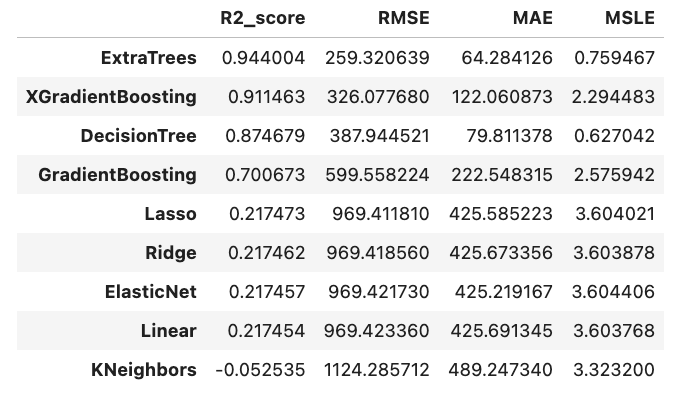

---------------

In [27]:
# Initialize the ExtraTreesRegressor
model = ExtraTreesRegressor(n_estimators=100, random_state=42, n_jobs=-1)

-------------------

# **Results --**

# **RUN THE BELOW SECTION TO TEST THE SAMPLE DATASETS --**

In [28]:
# Using sample_X and sample_y
#model.fit(sample_X, sample_y)

# Predicting the test set results
#predictions = model.predict(test)

# Create a submission DataFrame
#submission = pd.DataFrame({
    #'id': test['id'],
    #'sales': predictions
#})

-------------------

# **RUN THE BELOW SECTION TO TEST THE FULL X AND Y DATASETS --**

In [29]:
# Using X and y
model.fit(X, y)

# Predicting the test set results
predictions2 = model.predict(test)

# Create a submission DataFrame
submission = pd.DataFrame({
    'id': test['id'],
    'sales': predictions2
})

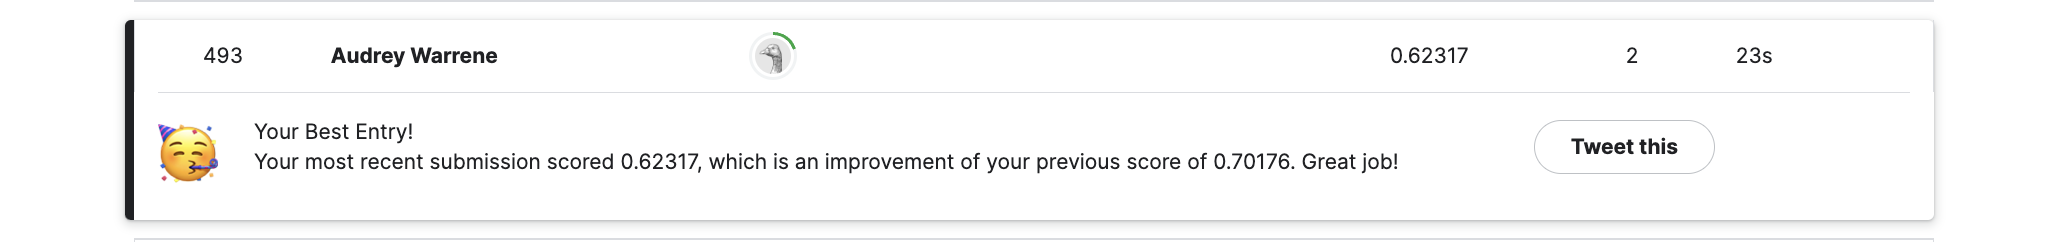

------------

# **SUBMISSION --**

In [30]:
# Save the predictions to a CSV file
submission.to_csv('/kaggle/working/submission.csv', index=False)